<div class="alert alert-info">

Были переданы данные о некоторых пользователях из нескольких городов, а также об их поездках. 
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
без подписки, или с подпиской Ultra.

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

2 Расстояние одной поездки в 
3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130 метров?

3 Необходимо проверить гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<div class="alert alert-info">
Есть два типа подписки - бесплатная (без подписки), и ультра. Они отличаются ценой за мин поездки и ценой за старт поездки. 
У нас есть данные по некоторому количеству пользователей: у кого какая подписка, и кто в каком городе сколько раз вызывал такси (и сколько на нём проехал) за промежуток с 2021-01-01 по 2021-12-30

#### Шаг 2. Предобработка данных

In [6]:
rides['date'] = pd.to_datetime(rides['date'])
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [7]:
print(users.isna().sum())
print(rides.isna().sum())
print(subscriptions.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


In [8]:
print(users.duplicated().sum())
print(rides.duplicated().sum())
print(subscriptions.duplicated().sum())

31
0
0


In [9]:
users = users.drop_duplicates()

<div class="alert alert-info">
Вывод: проблем с отсутствующими значениями не было - все данные заполнены. Дубликаты были только в датафрейме users - и мы от них успешно избавились.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

In [10]:
(users.city.value_counts()/users.city.count()).sort_values()

Москва            0.109518
Тюмень            0.117340
Омск              0.119296
Сочи              0.123207
Краснодар         0.125815
Ростов-на-Дону    0.129074
Екатеринбург      0.132986
Пятигорск         0.142764
Name: city, dtype: float64

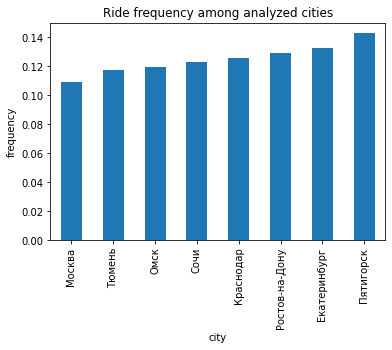

In [11]:
(users.city.value_counts()/users.city.count()).sort_values().plot(kind='bar')
plt.ylabel('frequency')
plt.xlabel('city')
plt.title('Ride frequency among analyzed cities')
plt.show()

<div class="alert alert-info">
как ни странно, из мск поступило меньше всего заказов, из пятигорска - больше всего (~14%)

<function matplotlib.pyplot.show(close=None, block=None)>

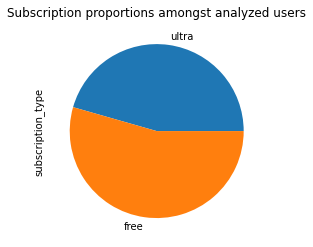

In [12]:
(users.subscription_type.value_counts()/users.city.count()).sort_values().plot(kind='pie')
plt.title('Subscription proportions amongst analyzed users')
plt.show

<div class="alert alert-info">
Чуть больше половины пользователей пользуются 'бесплатной' подпиской, остальные - подпиской 'ультра'

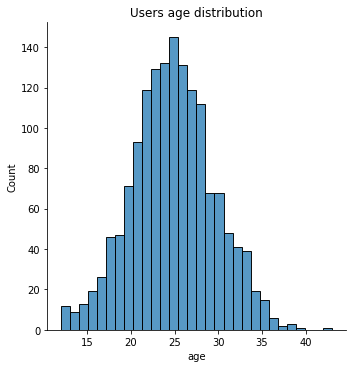

In [13]:
sns.displot(users.age)
plt.title('Users age distribution')
plt.show()

<div class="alert alert-info">
большинству пользователей - от 20 до 30 лет, средний возраст - 25. Старше сорока и младше тринадцати пользователей практически нет.

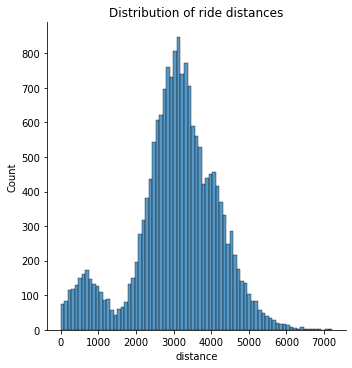

In [14]:
sns.displot(rides.distance)
plt.title('Distribution of ride distances')
plt.show()

<div class="alert alert-info">
здесь мы наблюдаем два пика - 0-1500 и 1500-6000. Скорее всего, более левый пик описывает малые города, правый - большие (e.g., Москва)

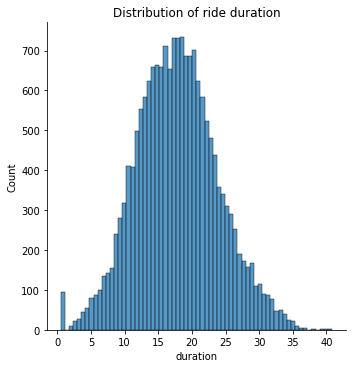

In [15]:
sns.displot(rides.duration)
plt.title('Distribution of ride duration')
plt.show()

<div class="alert alert-info">
Продолжительность поездок имеет нормальное распределение со средним примерно 20 минут. Есть небольшой пик на 1 минуте, скорее всего, передумавшие клиенты (например, клиент взял самокат, но понял, что самокат сломан).

<div class="alert alert-info">
Промежуточный вывод: был проведен исследовательский анализ исходных данных. Было выяснено, что большинство пользователей пользуются подпиской free, их средний возраст - около 25 лет, они чаще всего совершают поездки около 3 километров из небольших городов (чаще всего - из Пятигорска)

#### Шаг 4. Объединение данных

In [16]:
users_rides_merged = users.merge(rides, on='user_id')
users_rides_subscriptions_merged = users_rides_merged.merge(subscriptions, on='subscription_type')
users_rides_subscriptions_merged.head()
users_rides_subscriptions_merged.shape

(18068, 12)

In [17]:
users_with_subscription = users.query('subscription_type == "ultra"').merge(rides, on='user_id')
users_with_subscription = users_with_subscription.merge(subscriptions, on='subscription_type')
users_with_subscription.head()
users_with_subscription.shape

(6500, 12)

In [18]:
users_wo_subscription = users.query('subscription_type == "free"').merge(rides, on='user_id')
users_wo_subscription = users_wo_subscription.merge(subscriptions, on='subscription_type')
users_wo_subscription.head()
users_wo_subscription.shape

(11568, 12)

<div class="alert alert-info">
Сумма размерностей двух новых таблиц равна размерности таблицы, смердженной по всем данным - ничего не потерялось

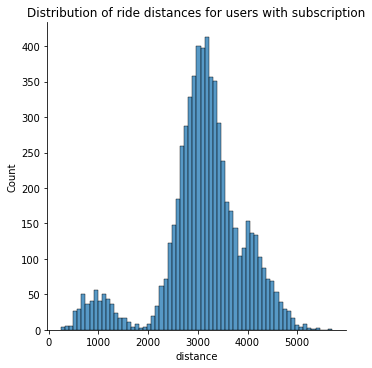

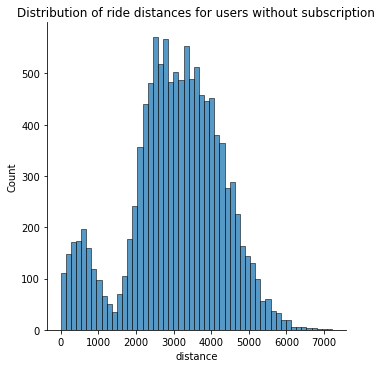

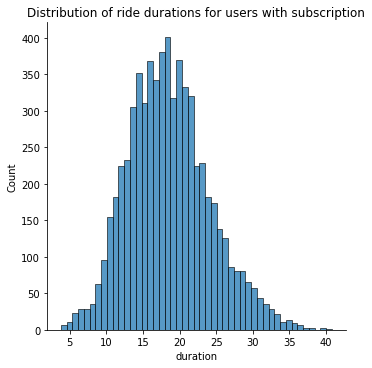

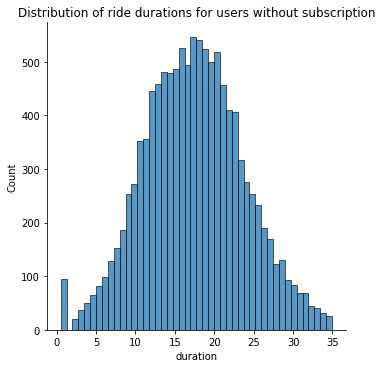

In [19]:
#Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

sns.displot(users_with_subscription.distance)
plt.title('Distribution of ride distances for users with subscription')
plt.show()

sns.displot(users_wo_subscription.distance)
plt.title('Distribution of ride distances for users without subscription')
plt.show()

sns.displot(users_with_subscription.duration)
plt.title('Distribution of ride durations for users with subscription')
plt.show()

sns.displot(users_wo_subscription.duration)
plt.title('Distribution of ride durations for users without subscription')
plt.show()

<div class="alert alert-info">
Люди без подписки чаще берут самокаты для коротких поездок (до 1.5 км), а максимальная дальность их поездок выше, чем у людей с пподпиской.

Также примечательно, что пик на 1 минуте поездки, который мы видели в предыдущем задании, сохраняется только на распределении, построенном на данных о людях без подписки - может, они уже после начала поездки решают, что такая поездка им невыгодна, и они решают идти пешком. Также их средняя и максимальная продолжительность поездки немного ниже, чем у людей с подпиской (18 против примерно 20 минут для среднего и 35 против 40 для максиммального)

#### Шаг 5. Подсчёт выручки

In [20]:
users_rides_subscriptions_merged.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


<div class="alert alert-info">
Округление времени поездки

In [21]:
users_rides_subscriptions_merged['duration'] = np.round(users_rides_subscriptions_merged['duration'], 0)
users_rides_subscriptions_merged.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.0,2021-08-28,8,6,0,199


In [24]:
all_aggr = users_rides_subscriptions_merged.groupby(['user_id', 'month']).agg({
    'distance': 'sum',
    'date': 'count',
    'duration': 'sum',
    'subscription_type': 'unique'
}).reset_index()
all_aggr.columns = ['user_id', 'month', 'distance', 'n_rides', 'duration', 'subscription']

all_aggr['subscription'] = [''.join(i) for i in all_aggr['subscription']]

print(all_aggr['subscription'].value_counts())
all_aggr.head()

free     6798
ultra    4533
Name: subscription, dtype: int64


,user_id,month,distance,n_rides,duration,subscription
0,1,1,7027.511294,2,42.0,ultra
1,1,4,754.159807,1,6.0,ultra
2,1,8,6723.470560,2,45.0,ultra
3,1,10,5809.911100,2,32.0,ultra
4,1,11,7003.499363,3,53.0,ultra


In [25]:
def revenue_by_month(df, terms = ['ultra', 'free']):
    if terms=='free':
        revenue = np.ceil(df['duration'])*8 + df['n_rides']*50
    else:
        revenue = np.ceil(df['duration'])*6 + 199
    return revenue

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v3:</b>
<br>Отлично! Теперь всё верно)
</div>

In [26]:
'''with_subscription_aggr['revenue'] = revenue_by_month(with_subscription_aggr, 'ultra')
with_subscription_aggr.head()'''

"with_subscription_aggr['revenue'] = revenue_by_month(with_subscription_aggr, 'ultra')\nwith_subscription_aggr.head()"

In [27]:
'''wo_subscription_aggr['revenue'] = revenue_by_month(wo_subscription_aggr, 'free')
wo_subscription_aggr.head()'''

"wo_subscription_aggr['revenue'] = revenue_by_month(wo_subscription_aggr, 'free')\nwo_subscription_aggr.head()"

In [28]:
all_aggr['revenue'] = all_aggr.apply(lambda x: revenue_by_month(x, x['subscription']), axis=1)
all_aggr.head()

,user_id,month,distance,n_rides,duration,subscription,revenue
0,1,1,7027.511294,2,42.0,ultra,451.0
1,1,4,754.159807,1,6.0,ultra,235.0
2,1,8,6723.470560,2,45.0,ultra,469.0
3,1,10,5809.911100,2,32.0,ultra,391.0
4,1,11,7003.499363,3,53.0,ultra,517.0


In [29]:
with_subscription_aggr = all_aggr.query('subscription=="ultra"')
wo_subscription_aggr = all_aggr.query('subscription=="free"')

In [30]:
with_subscription_aggr

,user_id,month,distance,n_rides,duration,subscription,revenue
0,1,1,7027.511294,2,42.0,ultra,451.0
1,1,4,754.159807,1,6.0,ultra,235.0
2,1,8,6723.470560,2,45.0,ultra,469.0
3,1,10,5809.911100,2,32.0,ultra,391.0
4,1,11,7003.499363,3,53.0,ultra,517.0
...,...,...,...,...,...,...,...
4528,699,6,4072.797406,1,17.0,ultra,301.0
4529,699,8,7018.324143,2,45.0,ultra,469.0
4530,699,9,6364.861911,2,30.0,ultra,379.0
4531,699,10,4707.845501,1,16.0,ultra,295.0


#### Шаг 6. Проверка гипотез

6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

<div class="alert alert-info">

H0: среднее время поездки у пользователей с подпиской и без одинаковое, либо у пользователей с подпиской меньше, чем у пользователей без подписки

H1: среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки

In [31]:
t_stat, p_value = st.ttest_ind(users_with_subscription.duration, users_wo_subscription.duration, 
                              alternative='greater')

if p_value < .05:
    print(f'''Принимаем гипотезу о том, что пользователи с подпиской тратят больше времени на поездки: 
          вероятность того, что эта гипотеза верна при данных наблюдениях, составляет примерно {1-p_value} (p-value теста = {p_value})''')
else:
    print(f'''Отвергаем гипотезу о том, что пользователи с подпиской тратят больше времени на поездки: 
     вероятность того, что эта гипотезк верна при данных наблюдениях, составляет {p_value}''')

Принимаем гипотезу о том, что пользователи с подпиской тратят больше времени на поездки: 
          вероятность того, что эта гипотеза верна при данных наблюдениях, составляет примерно 1.0 (p-value теста = 1.2804098316645618e-34)


6.2 Расстояние одной поездки в 
3130
3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130
3130 метров? Проверьте гипотезу и сделайте выводы.

<div class="alert alert-info">

H0: Cреднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

H1: Cреднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров

In [32]:
#насколько я поняла, тут опечатка, и оптимальное расстояние - 3130 м
target_distance = 3130

t_stat, p_value = st.ttest_1samp(users_with_subscription.distance, target_distance, alternative='greater')

if p_value < .05:
    print(f'''cреднее расстояние поездки пользователей с подпиской превышает заданное пороговое значения (3130 метров) 
    c вероятностью {1 - p_value}''')
else:
    print(f'''cреднее расстояние поездки пользователей с подпиской не превышает заданного порогового значения (3130 метров) 
    c вероятностью {p_value}''')

cреднее расстояние поездки пользователей с подпиской не превышает заданного порогового значения (3130 метров) 
    c вероятностью 0.9195368847849785


6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

<div class="alert alert-info">

H0: Помесячная выручка от пользователей с подпиской по месяцам не выше, чем выручка от пользователей без подписки

H1: Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [33]:
t_stat, p_value = st.ttest_ind(with_subscription_aggr.revenue, wo_subscription_aggr.revenue, 
                              alternative='greater')

if p_value < .05:
    print(f"пользователи с подпиской приносят больше помесячной выручки: p-value этого теста {p_value}")
else:
    print(f"пользователи с подпиской приносят не больше помесячной выручки, чем пользователи без подписки,  с вероятностью {p_value}")

пользователи с подпиской приносят больше помесячной выручки: p-value этого теста 1.7274069878387966e-37


<div class="alert alert-info">

Общий вывод: Были проанализированы данные сервиса GoFast о некоторых пользователях из нескольких городов, а также об их поездках.
    
    Данные были проверены на предмет пропущенных значений и дубликатов и очищены от них.
    
    Был проведен исследовательский анализ данных. Было выяснено, что большинство пользователей пользуются подпиской free, их средний возраст - около 25 лет, они чаще всего совершают поездки около 3 километров из небольших городов (чаще всего - из Пятигорска)
    
    Замечено, что люди без подписки чаще берут самокаты для коротких поездок (до 1.5 км), а максимальная дальность их поездок выше, чем у людей с подпиской.
    
    Была также подсчитана помесячная выручка для каждого пользователя и проверены три гипотезы: 
        
        1) Пользователи с подпиской тратят больше времени на поездки (подтверждена).
        2) Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров (подтверждена, самокаты изнашиваются с оптимальной скоростью).
        3)  Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки (подтверждена).
        
        Исходя из этого, можно следать вывод о том, что подписка в нынешнем виде выгодна компании - выручки они приносят больше, чем пользователи без подписки. Однако, они и расстояние в среднем проезжают бОльшее (а значит, и самокаты будут изнашиваться быстрее, хоть и в пределах ожидания) - нужно иметь это в виду и также проверить, не нивелируется ли выгода от подписки повышенными затратами на обслуживание самокатов.

6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

<div class="alert alert-info">

Ответ: H0: после обновления количество обращений в поддержку осталось на прежнем уровне или повысилось

H1: после обновления количество обращений в поддержку снизилось

Для ответа на вопрос разумно применить парный t-test (st.ttest_2samp), так как мы сравниваем количество обращений одного и того же пользователя до и после обновления. Альтернатива = 'less', так как мы хотим подтвердить или опровергнуть гипотезу о снижении количества обращений после обновления.